In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import csv
from bs4 import BeautifulSoup
from datetime import datetime, timedelta

import os
from pandas import Series
from pandas import concat
from pandas import read_csv

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf


from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, RNN, GRU, Dropout
from math import sqrt
from matplotlib import pyplot
from numpy import array
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)

from numpy.random import seed
seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)
tf.random.set_seed(2)

# Loading the data scraped from Delhi SLDC website

In [31]:
data = pd.read_csv('/kaggle/input/lstm-data-2023/lstm_data_2023_1.csv', header=None, names=['datetime', 'load'])
data.dropna(inplace=True)
data['datetime'] = pd.to_datetime((data['datetime']),dayfirst=True, format='mixed')
#data = data.set_index('datetime')
data

,datetime,load
0,2023-01-01 00:00:00,2377.87
1,2023-01-01 00:05:00,2327.74
2,2023-01-01 00:10:00,2297.35
3,2023-01-01 00:15:00,2287.87
4,2023-01-01 00:20:00,2243.37
...,...,...
102230,2023-12-30 22:40:00,2683.09
102231,2023-12-30 22:45:00,2667.26
102232,2023-12-30 22:50:00,2667.26
102233,2023-12-30 22:55:00,2667.26


### Checking the number of days present in the data

In [79]:
dates = []
for date in data.index.date:
    date_string =  date.strftime('%Y-%m-%d')
    dates.append(date_string)
dates = list(sorted(set(dates)))
len(dates)

364

In [33]:
data["datetime"] = data["datetime"].dt.strftime('%Y-%m-%d %H:%M:%S')
data

,datetime,load,day
0,2023-01-01 00:00:00,2377.87,0
1,2023-01-01 00:05:00,2327.74,0
2,2023-01-01 00:10:00,2297.35,0
3,2023-01-01 00:15:00,2287.87,0
4,2023-01-01 00:20:00,2243.37,0
...,...,...,...
102230,2023-12-30 22:40:00,2683.09,363
102231,2023-12-30 22:45:00,2667.26,363
102232,2023-12-30 22:50:00,2667.26,363
102233,2023-12-30 22:55:00,2667.26,363


In [32]:
data["day"] = data["datetime"].dt.dayofyear - data["datetime"].dt.dayofyear.min()
data

,datetime,load,day
0,2023-01-01 00:00:00,2377.87,0
1,2023-01-01 00:05:00,2327.74,0
2,2023-01-01 00:10:00,2297.35,0
3,2023-01-01 00:15:00,2287.87,0
4,2023-01-01 00:20:00,2243.37,0
...,...,...,...
102230,2023-12-30 22:40:00,2683.09,363
102231,2023-12-30 22:45:00,2667.26,363
102232,2023-12-30 22:50:00,2667.26,363
102233,2023-12-30 22:55:00,2667.26,363


In [34]:
def swap_columns(df, col1, col2):
    col_list = list(df.columns) # Create a list of column names
    x, y = col_list.index(col1), col_list.index(col2) # Get the indices of the two columns
    col_list[y], col_list[x] = col_list[x], col_list[y] # Swap the positions of the two columns in the list
    df = df[col_list] # Return a new dataframe with the reordered columns
    return df

# Use the function to swap the position of value and day columns
data = swap_columns(data, "load", "day")
data

,datetime,day,load
0,2023-01-01 00:00:00,0,2377.87
1,2023-01-01 00:05:00,0,2327.74
2,2023-01-01 00:10:00,0,2297.35
3,2023-01-01 00:15:00,0,2287.87
4,2023-01-01 00:20:00,0,2243.37
...,...,...,...
102230,2023-12-30 22:40:00,363,2683.09
102231,2023-12-30 22:45:00,363,2667.26
102232,2023-12-30 22:50:00,363,2667.26
102233,2023-12-30 22:55:00,363,2667.26


In [10]:
data[-288:]

,datetime,load,day
101947,2023-12-29 22:50:00,2703.48,362
101948,2023-12-29 22:55:00,2708.76,362
101949,2023-12-29 23:00:00,2600.62,362
101950,2023-12-29 23:05:00,2596.33,362
101951,2023-12-29 23:10:00,2569.81,362
...,...,...,...
102230,2023-12-30 22:40:00,2683.09,363
102231,2023-12-30 22:45:00,2667.26,363
102232,2023-12-30 22:50:00,2667.26,363
102233,2023-12-30 22:55:00,2667.26,363


In [6]:
! pip install ts2ml

  Obtaining dependency information for ts2ml from https://files.pythonhosted.org/packages/83/a0/290fa925a32633aaa7f2f080770dac0d04eeb63722cec89fc5b127c48845/ts2ml-1.0.1-py3-none-any.whl.metadata


### Filling the missing data

In [7]:
from ts2ml.core import add_missing_slots

In [35]:
df = add_missing_slots(data, datetime_col='datetime', entity_col='day', value_col='load', freq='5min')
df

100%|██████████| 364/364 [01:00<00:00,  6.03it/s]


,datetime,day,load
0,2023-01-01 00:00:00,0,2377.87
1,2023-01-01 00:05:00,0,2327.74
2,2023-01-01 00:10:00,0,2297.35
3,2023-01-01 00:15:00,0,2287.87
4,2023-01-01 00:20:00,0,2243.37
...,...,...,...
38154839,2023-12-30 22:40:00,363,2683.09
38154840,2023-12-30 22:45:00,363,2667.26
38154841,2023-12-30 22:50:00,363,2667.26
38154842,2023-12-30 22:55:00,363,2667.26


In [65]:

output = pd.DataFrame()
for i in range(364):   
    df2 = df.loc[df['day'] == i, ["datetime", 'load']][i*288:(i+1)*288]
    output = pd.concat([output, df2])
output

,datetime,load
0,2023-01-01 00:00:00,2377.87
1,2023-01-01 00:05:00,2327.74
2,2023-01-01 00:10:00,2297.35
3,2023-01-01 00:15:00,2287.87
4,2023-01-01 00:20:00,2243.37
...,...,...
38154839,2023-12-30 22:40:00,2683.09
38154840,2023-12-30 22:45:00,2667.26
38154841,2023-12-30 22:50:00,2667.26
38154842,2023-12-30 22:55:00,2667.26


In [66]:
output['datetime'] = pd.to_datetime((output['datetime']), format='%Y-%m-%d %H:%M:%S')
#output = output.set_index('datetime')

In [67]:
output[:8600]

,datetime,load
0,2023-01-01 00:00:00,2377.87
1,2023-01-01 00:05:00,2327.74
2,2023-01-01 00:10:00,2297.35
3,2023-01-01 00:15:00,2287.87
4,2023-01-01 00:20:00,2243.37
...,...,...
3048404,2023-01-30 20:15:00,3515.62
3048405,2023-01-30 20:20:00,3470.27
3048406,2023-01-30 20:25:00,3472.47
3048407,2023-01-30 20:30:00,3407.17


In [72]:
output.to_excel('/kaggle/working/2023_load_data_with_null.xlsx')

In [68]:
output2 = output.replace(0, np.nan)
output2

,datetime,load
0,2023-01-01 00:00:00,2377.87
1,2023-01-01 00:05:00,2327.74
2,2023-01-01 00:10:00,2297.35
3,2023-01-01 00:15:00,2287.87
4,2023-01-01 00:20:00,2243.37
...,...,...
38154839,2023-12-30 22:40:00,2683.09
38154840,2023-12-30 22:45:00,2667.26
38154841,2023-12-30 22:50:00,2667.26
38154842,2023-12-30 22:55:00,2667.26


<Axes: >

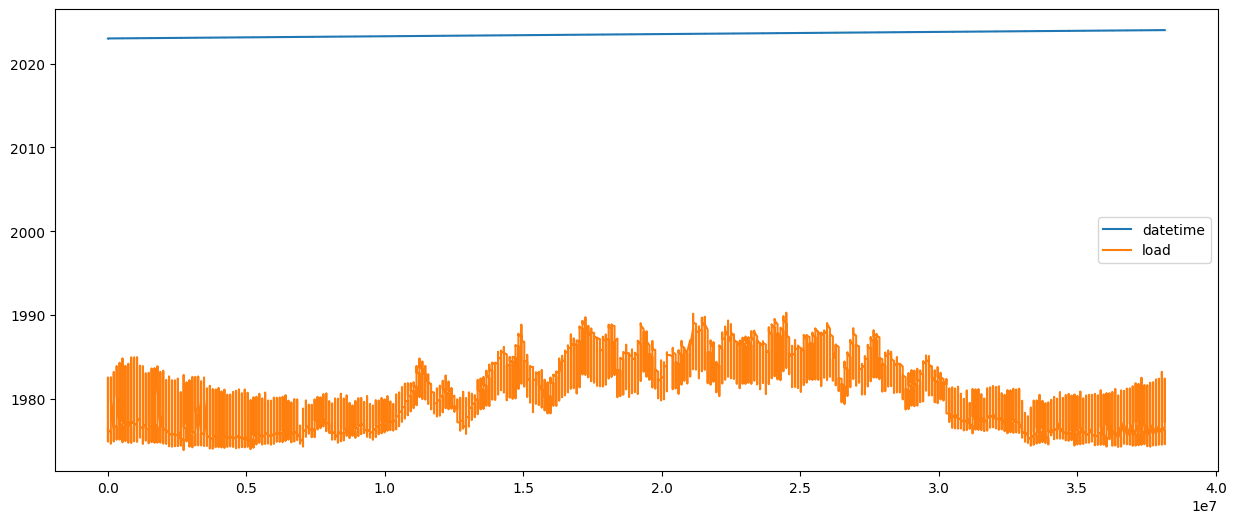

In [69]:
output2 = output2.fillna(method='ffill')
output2.plot()

# 1. Loading the Data

In [2]:
output2 = pd.read_excel('/kaggle/input/2023-load-data-clean/2023_load_data_clean (1).xlsx')
output2

,datetime,load
0,2023-01-01 00:00:00,2377.87
1,2023-01-01 00:05:00,2327.74
2,2023-01-01 00:10:00,2297.35
3,2023-01-01 00:15:00,2287.87
4,2023-01-01 00:20:00,2243.37
...,...,...
104816,2023-12-30 22:40:00,2683.09
104817,2023-12-30 22:45:00,2667.26
104818,2023-12-30 22:50:00,2667.26
104819,2023-12-30 22:55:00,2667.26


In [3]:
output2 = pd.read_csv('/kaggle/input/load-data-2024-cleaned/load_data_2024_cleaned2.csv')
output2

,datetime,load
0,1/3/2024 0:00,2335.50
1,1/3/2024 0:05,2288.39
2,1/3/2024 0:10,2258.62
3,1/3/2024 0:15,2214.56
4,1/3/2024 0:20,2178.84
...,...,...
6616,NaN,NaN
6617,NaN,NaN
6618,NaN,NaN
6619,NaN,NaN


In [4]:
output2.dropna(inplace=True)
output2

,datetime,load
0,1/3/2024 0:00,2335.50
1,1/3/2024 0:05,2288.39
2,1/3/2024 0:10,2258.62
3,1/3/2024 0:15,2214.56
4,1/3/2024 0:20,2178.84
...,...,...
6331,1/25/2024 23:35,3656.19
6332,1/25/2024 23:40,3656.19
6333,1/25/2024 23:45,3656.19
6334,1/25/2024 23:50,3656.19


In [7]:
output2['datetime'] = pd.to_datetime((output2['datetime']), format='%m/%d/%Y %H:%M')
output2

,datetime,load
0,2024-01-03 00:00:00,2335.50
1,2024-01-03 00:05:00,2288.39
2,2024-01-03 00:10:00,2258.62
3,2024-01-03 00:15:00,2214.56
4,2024-01-03 00:20:00,2178.84
...,...,...
6331,2024-01-25 23:35:00,3656.19
6332,2024-01-25 23:40:00,3656.19
6333,2024-01-25 23:45:00,3656.19
6334,2024-01-25 23:50:00,3656.19


In [4]:
missing_11 = pd.DataFrame({'datetime': ['2023-12-30 23:05:00','2023-12-30 23:10:00', '2023-12-30 23:15:00','2023-12-30 23:20:00', '2023-12-30 23:25:00','2023-12-30 23:30:00','2023-12-30 23:35:00','2023-12-30 23:40:00','2023-12-30 23:45:00','2023-12-30 23:50:00','2023-12-30 23:55:00'],
                          'load': [2667.26,2667.26,2667.26,2667.26,2667.26,2667.26,2667.26,2667.26,2667.26,2667.26,2667.26,]})
missing_11

,datetime,load
0,2023-12-30 23:05:00,2667.26
1,2023-12-30 23:10:00,2667.26
2,2023-12-30 23:15:00,2667.26
3,2023-12-30 23:20:00,2667.26
4,2023-12-30 23:25:00,2667.26
5,2023-12-30 23:30:00,2667.26
6,2023-12-30 23:35:00,2667.26
7,2023-12-30 23:40:00,2667.26
8,2023-12-30 23:45:00,2667.26
9,2023-12-30 23:50:00,2667.26


In [5]:
output3 = pd.concat([output2, missing_11])
output3

,datetime,load
0,2023-01-01 00:00:00,2377.87
1,2023-01-01 00:05:00,2327.74
2,2023-01-01 00:10:00,2297.35
3,2023-01-01 00:15:00,2287.87
4,2023-01-01 00:20:00,2243.37
...,...,...
6,2023-12-30 23:35:00,2667.26
7,2023-12-30 23:40:00,2667.26
8,2023-12-30 23:45:00,2667.26
9,2023-12-30 23:50:00,2667.26


In [6]:
output3['datetime'] = pd.to_datetime((output3['datetime']), format='%Y-%m-%d %H:%M:%S')



In [8]:
data = output2.set_index('datetime')
data

,load
datetime,
2023-01-01 00:00:00,2377.87
2023-01-01 00:05:00,2327.74
2023-01-01 00:10:00,2297.35
2023-01-01 00:15:00,2287.87
2023-01-01 00:20:00,2243.37
...,...
2023-12-30 22:40:00,2683.09
2023-12-30 22:45:00,2667.26
2023-12-30 22:50:00,2667.26


In [9]:
data.to_csv('/kaggle/working/final_2024_load_data_clean3.csv')

In [4]:
data = pd.read_excel('/kaggle/input/2023-load-data-clean/2023_load_data_clean (1).xlsx')
data

,datetime,load
0,2023-01-01 00:00:00,2377.87
1,2023-01-01 00:05:00,2327.74
2,2023-01-01 00:10:00,2297.35
3,2023-01-01 00:15:00,2287.87
4,2023-01-01 00:20:00,2243.37
...,...,...
104816,2023-12-30 22:40:00,2683.09
104817,2023-12-30 22:45:00,2667.26
104818,2023-12-30 22:50:00,2667.26
104819,2023-12-30 22:55:00,2667.26


Text(0, 0.5, 'Load in MW')

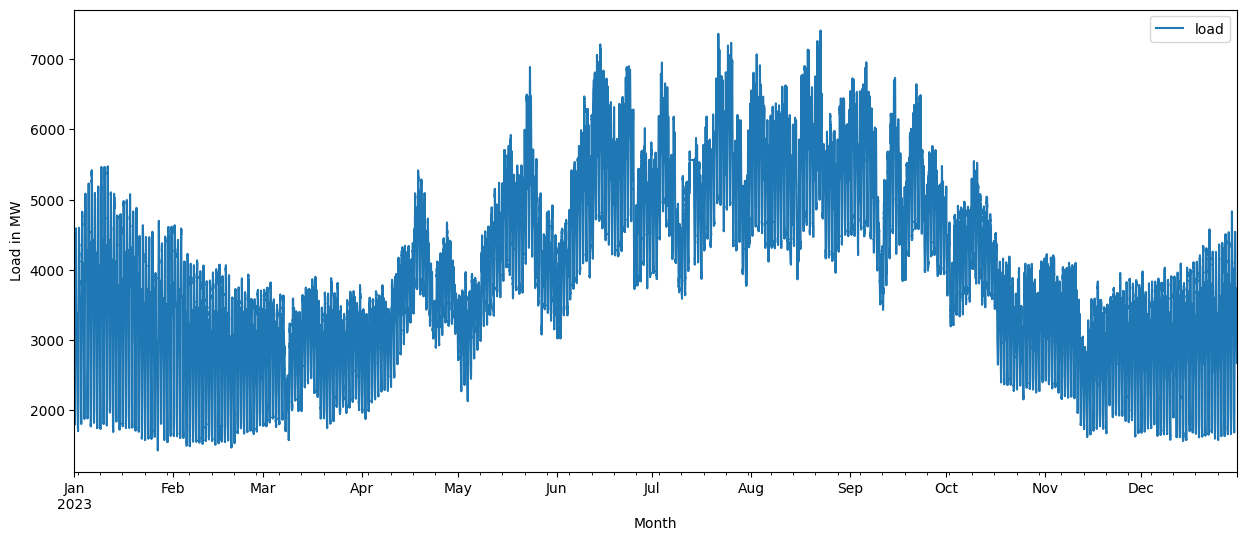

In [8]:
data.plot()
plt.xlabel('Month')
plt.ylabel('Load in MW')
#plt.savefig('/kaggle/working/2023_load_plot.png', dpi=900)

In [9]:
data

,load
datetime,
2023-01-01 00:00:00,2377.87
2023-01-01 00:05:00,2327.74
2023-01-01 00:10:00,2297.35
2023-01-01 00:15:00,2287.87
2023-01-01 00:20:00,2243.37
...,...
2023-12-30 22:40:00,2683.09
2023-12-30 22:45:00,2667.26
2023-12-30 22:50:00,2667.26


In [64]:
output2.to_excel('/kaggle/working/2023_load_data_clean.xlsx')

### Plotting the Load Data for the entire year of 2023

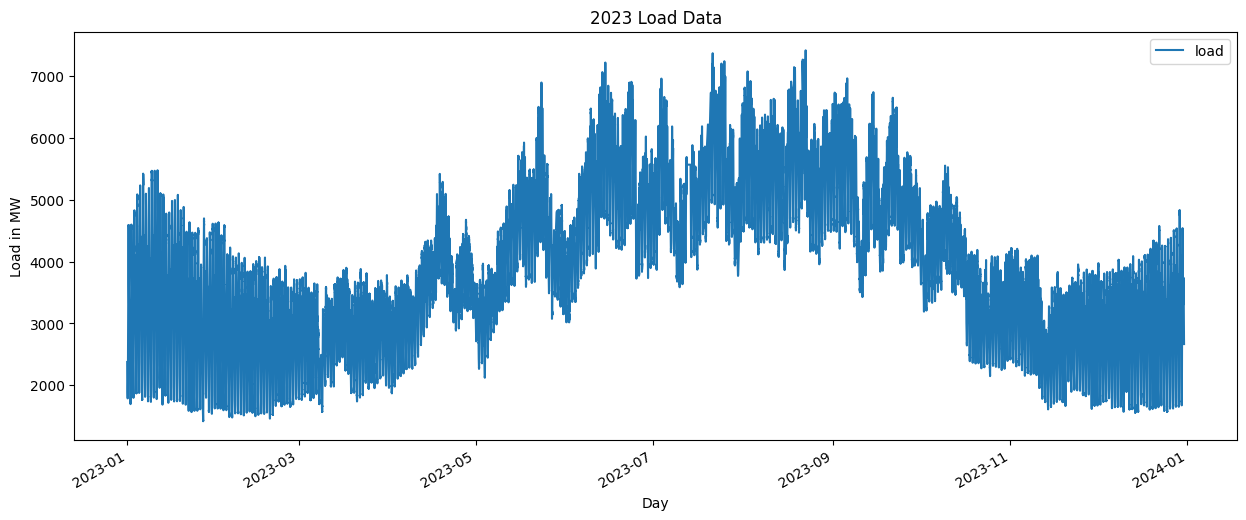

In [5]:
data.plot()
plt.ylabel('Load in MW')
plt.xlabel('Day')
plt.title('2023 Load Data')
plt.savefig('/kaggle/working/full_year_load_2023.png', dpi = 600)

Text(0.5, 1.0, '2024 Load Data')

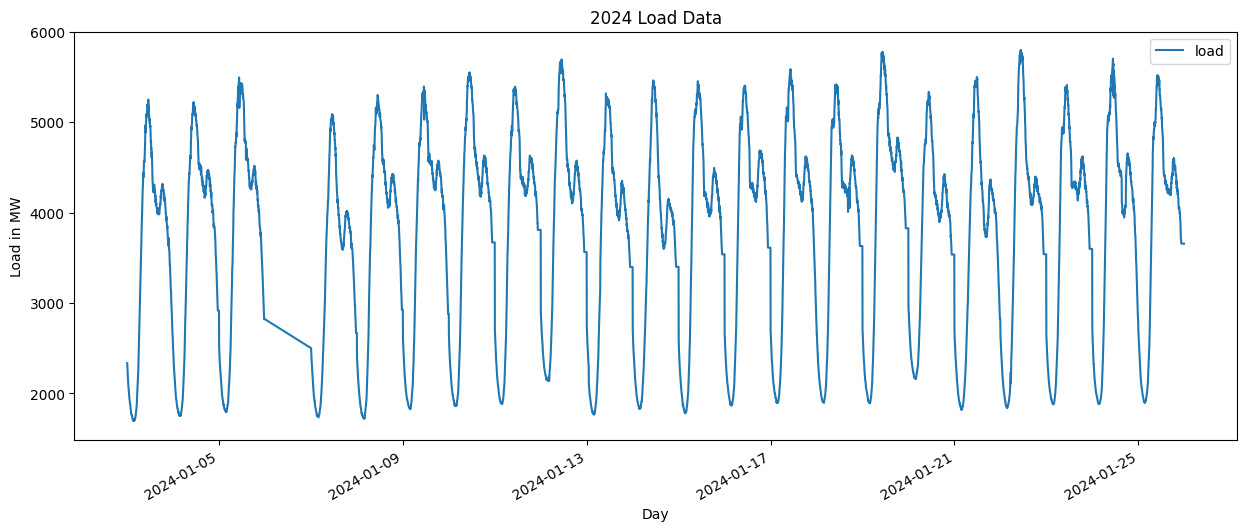

In [10]:
data.plot()
plt.ylabel('Load in MW')
plt.xlabel('Day')
plt.title('2024 Load Data')

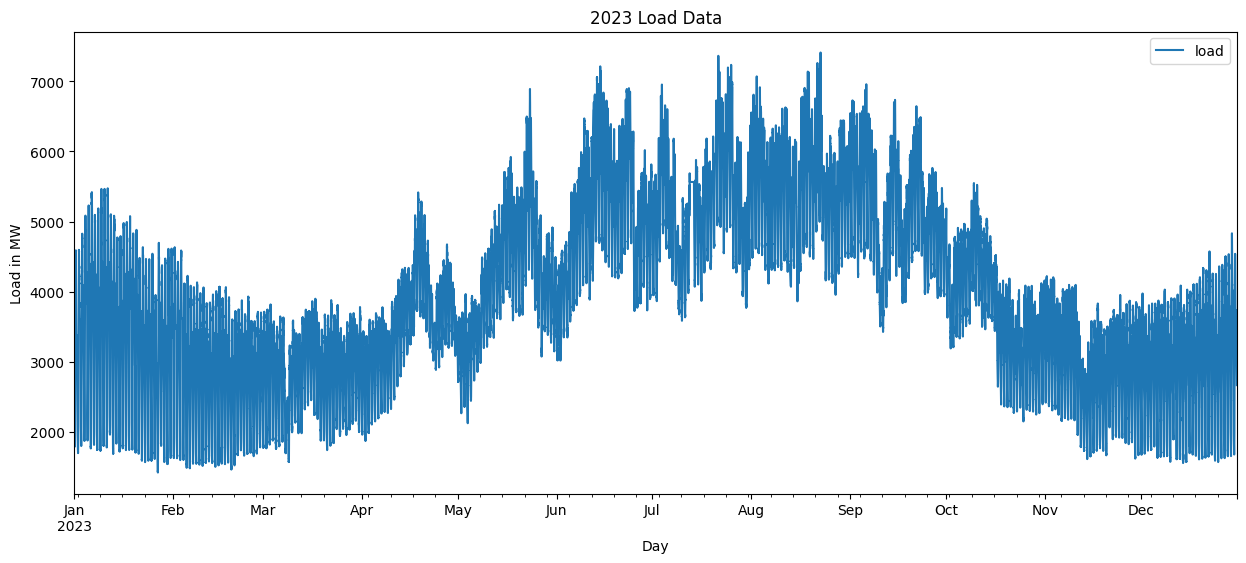

In [10]:
data.plot()
plt.ylabel('Load in MW')
plt.xlabel('Day')
plt.title('2023 Load Data')
plt.savefig('/kaggle/working/full_year_load_2023.png', dpi = 600)

# Data Analysis for 2023 Load Data

In [91]:
data = data[:8600]
data

,load
datetime,
2023-01-01 00:00:00,2377.87
2023-01-01 00:05:00,2327.74
2023-01-01 00:10:00,2297.35
2023-01-01 00:15:00,2287.87
2023-01-01 00:20:00,2243.37
...,...
2023-01-31 16:55:00,3522.89
2023-01-31 17:00:00,3516.62
2023-01-31 17:05:00,3565.33


In [98]:
sorted(set(data.index.time))

AttributeError: 'RangeIndex' object has no attribute 'time'

In [97]:
data.loc[(data['datetime']>='2023-01-01') & (data['datetime'] < '2023-01-02')]

,datetime,load
0,2023-01-01 00:00:00,2377.87
1,2023-01-01 00:05:00,2327.74
2,2023-01-01 00:10:00,2297.35
3,2023-01-01 00:15:00,2287.87
4,2023-01-01 00:20:00,2243.37
...,...,...
281,2023-01-01 23:25:00,2424.24
282,2023-01-01 23:30:00,2386.60
283,2023-01-01 23:35:00,2354.76
284,2023-01-01 23:40:00,2324.46


In [ ]:
output2.loc[(output2['datetime']>='2023-01-01') & (output['datetime'] < '2023-01-02')]

In [10]:
df = pd.DataFrame(columns=['time'] + list(map(str, range(int(364)))))
for idx, time in enumerate(sorted(set(data.index.time))):
    list_len = len(list(data.at_time(time)['load'].values))
    new_row_df = pd.DataFrame(columns=list(df.columns[:list_len+1]), data=[[time.strftime(format='%H:%M:%S')] + list(data.at_time(time)['load'].values)])
    df = pd.concat([df, new_row_df])

In [12]:
df = pd.DataFrame(columns=['time'] + list(map(str, range(int(22)))))
for idx, time in enumerate(sorted(set(data.index.time))):
    list_len = len(list(data.at_time(time)['load'].values))
    new_row_df = pd.DataFrame(columns=list(df.columns[:list_len+1]), data=[[time.strftime(format='%H:%M:%S')] + list(data.at_time(time)['load'].values)])
    df = pd.concat([df, new_row_df])

In [11]:
df

,time,0,1,2,3,4,5,6,7,8,...,354,355,356,357,358,359,360,361,362,363
0,00:00:00,2377.87,2207.84,2331.98,2439.32,2554.86,2466.20,2528.33,2503.27,2440.68,...,2095.88,2115.30,2180.88,2068.25,2018.49,2069.70,2104.60,2150.01,2179.82,2244.43
0,00:05:00,2327.74,2153.24,2298.50,2392.77,2519.90,2416.30,2479.52,2446.71,2401.93,...,2055.99,2096.57,2109.32,2037.70,1970.27,2048.09,2060.78,2131.42,2139.54,2196.02
0,00:10:00,2297.35,2145.65,2280.86,2366.20,2484.61,2376.10,2445.69,2415.36,2340.46,...,2022.50,2071.65,2104.78,2006.57,1961.73,2020.89,2025.63,2101.29,2094.29,2160.47
0,00:15:00,2287.87,2115.98,2247.05,2331.64,2433.20,2340.16,2416.16,2371.69,2312.29,...,2012.79,2037.15,2070.12,1970.99,1926.66,1995.22,2012.77,2052.61,2093.52,2134.73
0,00:20:00,2243.37,2063.49,2234.55,2308.88,2407.34,2320.06,2378.31,2325.92,2268.09,...,1988.57,2001.91,2049.37,1964.15,1919.86,1966.54,1994.70,2050.87,2056.34,2107.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,23:35:00,2354.76,3597.60,2633.15,3835.11,2679.28,2774.46,2731.69,2675.45,2771.68,...,2654.63,2295.75,2539.53,2434.05,2565.23,2404.19,2487.83,2410.97,2455.95,NaN
0,23:40:00,2324.46,3597.60,2576.59,3835.11,2632.49,2714.47,2682.68,2675.45,2730.50,...,2654.63,2264.54,2539.53,2434.05,2565.23,2404.19,2487.83,2410.97,2455.95,NaN
0,23:45:00,2302.55,3597.60,2549.85,3835.11,2589.07,2681.27,2652.87,2675.45,2685.85,...,2654.63,2249.57,2539.53,2434.05,2565.23,2404.19,2487.83,2410.97,2455.95,NaN
0,23:50:00,2302.55,3597.60,2487.84,3835.11,2589.07,2681.27,2652.87,2675.45,2685.85,...,2654.63,2227.84,2539.53,2434.05,2565.23,2404.19,2487.83,2410.97,2455.95,NaN


In [ ]:
sorted(set(data.index.time))

In [82]:
data.at_time(datetime.time(15,50))

TypeError: descriptor 'time' for 'datetime.datetime' objects doesn't apply to a 'int' object

In [ ]:
new_row_df = pd.DataFrame(columns=list(df.columns[:list_len+1]), data=[[time.strftime(format='%H:%M:%S')] + list(data.at_time(time)['load'].values)])

In [75]:
df.to_excel('/kaggle/working/jan1to10.xlsx')

In [24]:
import math
null_columns = []
null_index = []
index = -1
for column in df.iloc[:, 1:365].columns:
    index +=1
    column = list(df[column])
    na_counter = 0
    for data in column:
        if math.isnan(float(data)):
            na_counter +=1
    if na_counter >=1:
        null_columns.append(column)
        null_index.append(index)
print(len(null_columns))
print(null_index)

0
[]


## Predicting Load on 1st March 2023 using data from 1st Jan 2023 to 28th February 2023

### 1. Selecting the data for the months of January and February from the overall dataset

In [12]:
df = df.set_index('time')

In [13]:
df2 = df

In [14]:
df2 = df.iloc[:, :60] #Slicing the data for Jan and Feb 
df2

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
time,,,,,,,,,,,,,,,,,,,,,
00:00:00,2377.87,2207.84,2331.98,2439.32,2554.86,2466.20,2528.33,2503.27,2440.68,2552.82,...,1862.05,2020.07,2083.81,2001.45,2018.52,2065.24,2012.69,2025.55,2118.58,2130.35
00:05:00,2327.74,2153.24,2298.50,2392.77,2519.90,2416.30,2479.52,2446.71,2401.93,2473.19,...,1834.24,1990.75,2060.86,1983.47,1986.62,2043.07,1977.02,1996.13,2087.24,2094.11
00:10:00,2297.35,2145.65,2280.86,2366.20,2484.61,2376.10,2445.69,2415.36,2340.46,2480.63,...,1814.22,2002.74,2049.62,1984.10,1986.69,2050.74,1955.92,1988.25,2067.26,2074.91
00:15:00,2287.87,2115.98,2247.05,2331.64,2433.20,2340.16,2416.16,2371.69,2312.29,2412.66,...,1802.64,1967.23,2059.11,1959.76,1967.28,2019.47,1941.94,1977.57,2060.53,2058.84
00:20:00,2243.37,2063.49,2234.55,2308.88,2407.34,2320.06,2378.31,2325.92,2268.09,2364.73,...,1787.81,1949.36,2027.93,1945.18,1950.06,1998.27,1937.87,1943.39,2041.41,2052.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23:35:00,2354.76,3597.60,2633.15,3835.11,2679.28,2774.46,2731.69,2675.45,2771.68,2750.73,...,2124.44,2178.42,2111.21,2100.20,2192.02,2084.79,2130.30,2200.18,2170.72,2207.75
23:40:00,2324.46,3597.60,2576.59,3835.11,2632.49,2714.47,2682.68,2675.45,2730.50,2695.49,...,2110.13,2145.36,2088.63,2091.46,2192.02,2084.79,2130.30,2189.37,2170.72,2207.75
23:45:00,2302.55,3597.60,2549.85,3835.11,2589.07,2681.27,2652.87,2675.45,2685.85,2672.05,...,2083.28,2121.87,2087.76,2094.46,2192.02,2084.79,2130.30,2169.16,2170.72,2207.75


In [15]:
df2 = df2.fillna(method='ffill')
df2

,time,0,1,2,3,4,5,6,7,8,...,49,50,51,52,53,54,55,56,57,58
0,00:00:00,2377.87,2207.84,2331.98,2439.32,2554.86,2466.20,2528.33,2503.27,2440.68,...,1822.95,1862.05,2020.07,2083.81,2001.45,2018.52,2065.24,2012.69,2025.55,2118.58
0,00:05:00,2327.74,2153.24,2298.50,2392.77,2519.90,2416.30,2479.52,2446.71,2401.93,...,1797.54,1834.24,1990.75,2060.86,1983.47,1986.62,2043.07,1977.02,1996.13,2087.24
0,00:10:00,2297.35,2145.65,2280.86,2366.20,2484.61,2376.10,2445.69,2415.36,2340.46,...,1779.11,1814.22,2002.74,2049.62,1984.10,1986.69,2050.74,1955.92,1988.25,2067.26
0,00:15:00,2287.87,2115.98,2247.05,2331.64,2433.20,2340.16,2416.16,2371.69,2312.29,...,1769.63,1802.64,1967.23,2059.11,1959.76,1967.28,2019.47,1941.94,1977.57,2060.53
0,00:20:00,2243.37,2063.49,2234.55,2308.88,2407.34,2320.06,2378.31,2325.92,2268.09,...,1737.84,1787.81,1949.36,2027.93,1945.18,1950.06,1998.27,1937.87,1943.39,2041.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,23:35:00,2354.76,2633.15,2679.28,2774.46,2731.69,2675.45,2771.68,2750.73,2930.41,...,2207.75,2273.93,2297.44,2193.75,2255.77,2098.97,1892.30,2469.47,2343.92,2365.52
0,23:40:00,2324.46,2576.59,2632.49,2714.47,2682.68,2730.50,2695.49,2871.90,2532.03,...,2723.70,2747.52,2840.10,2667.92,2625.59,2240.98,2222.35,2077.94,2236.41,2210.20
0,23:45:00,2302.55,2549.85,2589.07,2681.27,2652.87,2685.85,2672.05,2817.06,2511.40,...,2364.07,2226.13,2325.29,2272.22,2403.30,2717.98,2935.32,3115.03,3346.99,3582.26
0,23:50:00,2487.84,2587.78,2438.54,2543.36,2492.91,2357.27,2145.60,2146.26,2108.90,...,5172.06,5320.46,5484.00,5960.14,6450.65,5306.71,4499.82,5046.81,4486.26,4239.01


In [14]:
df2 = df2.set_index('time')
df2

KeyError: "None of ['time'] are in the columns"

### Making the data stationary by method of differencing

In [15]:
dt_df = df2.diff(1, axis=1) # Detrending by differencing
dt_df = dt_df.dropna(axis=1) # Dropping NA values created due to deterending
dt_df

,1,2,3,4,5,6,7,8,9,10,...,50,51,52,53,54,55,56,57,58,59
time,,,,,,,,,,,,,,,,,,,,,
00:00:00,-170.03,124.14,107.34,115.54,-88.66,62.13,-25.06,-62.59,112.14,-47.99,...,39.10,158.02,63.74,-82.36,17.07,46.72,-52.55,12.86,93.03,11.77
00:05:00,-174.50,145.26,94.27,127.13,-103.60,63.22,-32.81,-44.78,71.26,-30.68,...,36.70,156.51,70.11,-77.39,3.15,56.45,-66.05,19.11,91.11,6.87
00:10:00,-151.70,135.21,85.34,118.41,-108.51,69.59,-30.33,-74.90,140.17,-71.46,...,35.11,188.52,46.88,-65.52,2.59,64.05,-94.82,32.33,79.01,7.65
00:15:00,-171.89,131.07,84.59,101.56,-93.04,76.00,-44.47,-59.40,100.37,-31.04,...,33.01,164.59,91.88,-99.35,7.52,52.19,-77.53,35.63,82.96,-1.69
00:20:00,-179.88,171.06,74.33,98.46,-87.28,58.25,-52.39,-57.83,96.64,-26.16,...,49.97,161.55,78.57,-82.75,4.88,48.21,-60.40,5.52,98.02,10.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23:35:00,1242.84,-964.45,1201.96,-1155.83,95.18,-42.77,-56.24,96.23,-20.95,179.68,...,189.23,53.98,-67.21,-11.01,91.82,-107.23,45.51,69.88,-29.46,37.03
23:40:00,1273.14,-1021.01,1258.52,-1202.62,81.98,-31.79,-7.23,55.05,-35.01,176.41,...,144.95,35.23,-56.73,2.83,100.56,-107.23,45.51,59.07,-18.65,37.03
23:45:00,1295.05,-1047.75,1285.26,-1246.04,92.20,-28.40,22.58,10.40,-13.80,145.01,...,164.66,38.59,-34.11,6.70,97.56,-107.23,45.51,38.86,1.56,37.03


In [16]:
dt_df = dt_df.to_numpy() #Converting dataframe to numpy array

### 2. Splitting the dataset into training and validation sets

In [17]:
split_idx = int(len(dt_df) * 0.8)
train, val = dt_df[:split_idx, :], dt_df[split_idx:, :]
train.shape, val.shape

((230, 59), (58, 59))

### 3. Data Preprocessing 

In [18]:
def prepare_data(data, nlags):
    '''prepares data for LSTM model, x=last nlags values, y=(nlags+1)'th value'''
    data_x, data_y = [], []
    for i in range(data.shape[0]):
        for j in range(0, data.shape[1]-nlags):
            data_x.append(data[i, j:j+nlags])
            data_y.append(data[i, j+nlags])
    data_x = np.array(data_x)
    data_y = np.array(data_y).reshape(-1, 1)
    return data_x, data_y

In [29]:
# number of previous days to use for prediction
nlags = 10 
train_x, train_y = prepare_data(train, nlags)
val_x, val_y = prepare_data(val, nlags)
train_x.shape, train_y.shape, val_x.shape, val_y.shape

((11270, 10), (11270, 1), (2842, 10), (2842, 1))

In [21]:
train_x = train_x.reshape(train_x.shape[0], 1, nlags)
val_x = val_x.reshape(val_x.shape[0], 1, nlags)
train_x.shape, val_x.shape

((2530, 1, 10), (638, 1, 10))

In [30]:
df_last_nlags_plus_one = df2.loc[:, df2.columns[-nlags-1:]] # slice last nlags+1 days from df, will be used in prediction of yesterday's data
df_last_nlags_plus_one.head()

,49,50,51,52,53,54,55,56,57,58,59
time,,,,,,,,,,,
00:00:00,1822.95,1862.05,2020.07,2083.81,2001.45,2018.52,2065.24,2012.69,2025.55,2118.58,2130.35
00:05:00,1797.54,1834.24,1990.75,2060.86,1983.47,1986.62,2043.07,1977.02,1996.13,2087.24,2094.11
00:10:00,1779.11,1814.22,2002.74,2049.62,1984.10,1986.69,2050.74,1955.92,1988.25,2067.26,2074.91
00:15:00,1769.63,1802.64,1967.23,2059.11,1959.76,1967.28,2019.47,1941.94,1977.57,2060.53,2058.84
00:20:00,1737.84,1787.81,1949.36,2027.93,1945.18,1950.06,1998.27,1937.87,1943.39,2041.41,2052.08


### 4. Selecting data from last 10 days

In [31]:
## taking last 10 days, differencing and dropping the nan value
dt_df_last_nlags = df_last_nlags_plus_one.diff(1, axis=1).dropna(axis=1) 
dt_df_last_nlags

,50,51,52,53,54,55,56,57,58,59
time,,,,,,,,,,
00:00:00,39.10,158.02,63.74,-82.36,17.07,46.72,-52.55,12.86,93.03,11.77
00:05:00,36.70,156.51,70.11,-77.39,3.15,56.45,-66.05,19.11,91.11,6.87
00:10:00,35.11,188.52,46.88,-65.52,2.59,64.05,-94.82,32.33,79.01,7.65
00:15:00,33.01,164.59,91.88,-99.35,7.52,52.19,-77.53,35.63,82.96,-1.69
00:20:00,49.97,161.55,78.57,-82.75,4.88,48.21,-60.40,5.52,98.02,10.67
...,...,...,...,...,...,...,...,...,...,...
23:35:00,189.23,53.98,-67.21,-11.01,91.82,-107.23,45.51,69.88,-29.46,37.03
23:40:00,144.95,35.23,-56.73,2.83,100.56,-107.23,45.51,59.07,-18.65,37.03
23:45:00,164.66,38.59,-34.11,6.70,97.56,-107.23,45.51,38.86,1.56,37.03


In [32]:
dt_df_last_nlags = dt_df_last_nlags.to_numpy() #Converting dataframe to numpy array

In [33]:
X = dt_df_last_nlags.reshape(dt_df_last_nlags.shape[0], 1, nlags)  # nlags=20
X.shape

(288, 1, 10)

## 5. Defining the LSTM model

In [34]:
model = Sequential()
model.add(LSTM(1, batch_input_shape=(1, 1, 10), stateful=True))
# model.add(LSTM(1, stateful=True, return_sequences=True))
# model.add(LSTM(1, stateful=True))
# model.add(Dense(train_y.shape[1]))
model.add(Dense(train_y.shape[1]))
model.compile(loss='mean_squared_error', optimizer='sgd')

## 6. Training the model

In [35]:
batch_size = 1 # batch size to train the models on
history = model.fit(train_x, train_y, epochs=20, batch_size=batch_size, verbose=1, validation_data=(val_x, val_y), shuffle=False)

Epoch 1/20


ValueError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 1, 10), found shape=(1, 10)


In [ ]:
early_stopping_counter = 0
last_loss = np.inf
batch_size = 1
for i in range(10):
    history = model.fit(train_x, train_y, epochs=1, batch_size=batch_size, verbose=1, validation_data=(val_x, val_y), shuffle=False)
    model.reset_states()
    val_loss = history.history['val_loss'][0]
    if val_loss > last_loss:
        early_stopping_counter += 1
    else:    
        early_stopping_counter = 0
    last_loss = val_loss
    if early_stopping_counter == 3:
#         break
        pass

### Loading the Saved model

In [41]:
from keras.models import load_model
model = load_model('/kaggle/input/march-model-rmse-60/march_model_rmse_60.keras')

## 7. Using the model to make predictions

In [28]:
batch_size = 1
val_y_pred = model.predict(val_x, batch_size=batch_size, verbose=1)

# predict for today's values
Y = model.predict(X, batch_size=batch_size)  

# last day's values added to inv_Y to get it to original scale
rescaled_Y = [x+y for x, y in zip(Y[:, 0], df2.iloc[:, -1])]

288/288 [==============================] - 1s 2ms/step


In [24]:
batch_size = 1
val_y_pred = model.predict(val_x, batch_size=batch_size, verbose=1)
#inverted_val_y = scaler.inverse_transform(val_y)
#inverted_val_y_pred = scaler.inverse_transform(val_y_pred)
Y = model.predict(X, batch_size=batch_size)  # predict for today's values
#inv_Y = scaler.inverse_transform(Y)  # invert to detrended values' scale
rescaled_Y = [x+y for x, y in zip(Y[:, 0], df2.iloc[:, -1])]  # last day's values added to inv_Y to get it to original scale

288/288 [==============================] - 0s 1ms/step


## 8. Plotting the predicted values

<Axes: xlabel='time'>

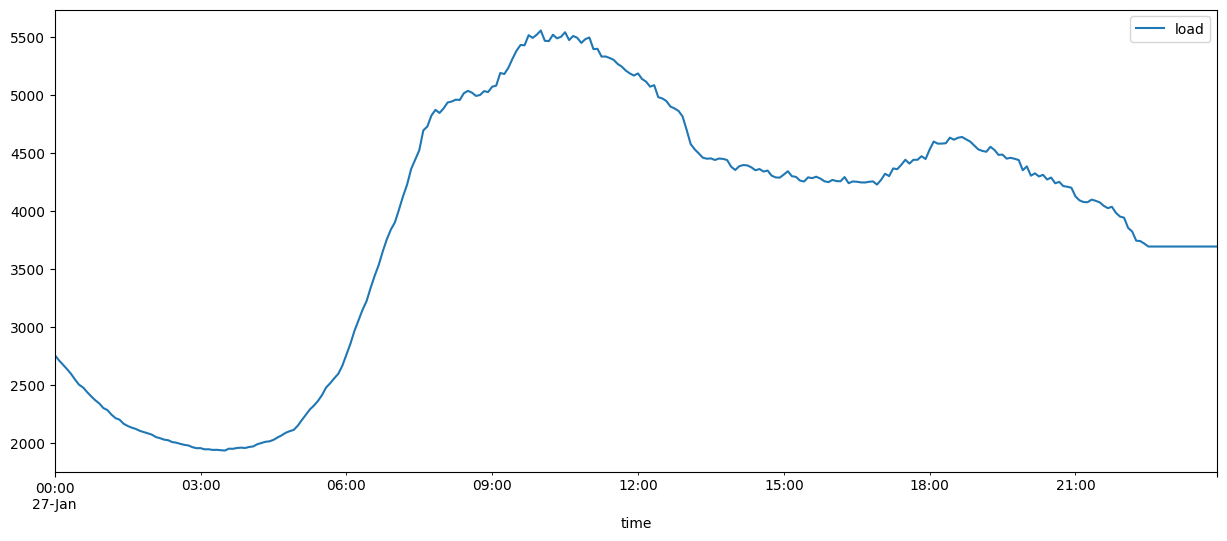

In [29]:
pred_df = pd.DataFrame(columns=["time", "load"])
pred_df["time"] = list(df2.index)
pred_df["load"] = rescaled_Y
pred_df['time'] = pd.to_datetime((pred_df['time']),dayfirst=True, format='mixed')
pred_df = pred_df.set_index('time')
pred_df.plot()

<Axes: xlabel='time'>

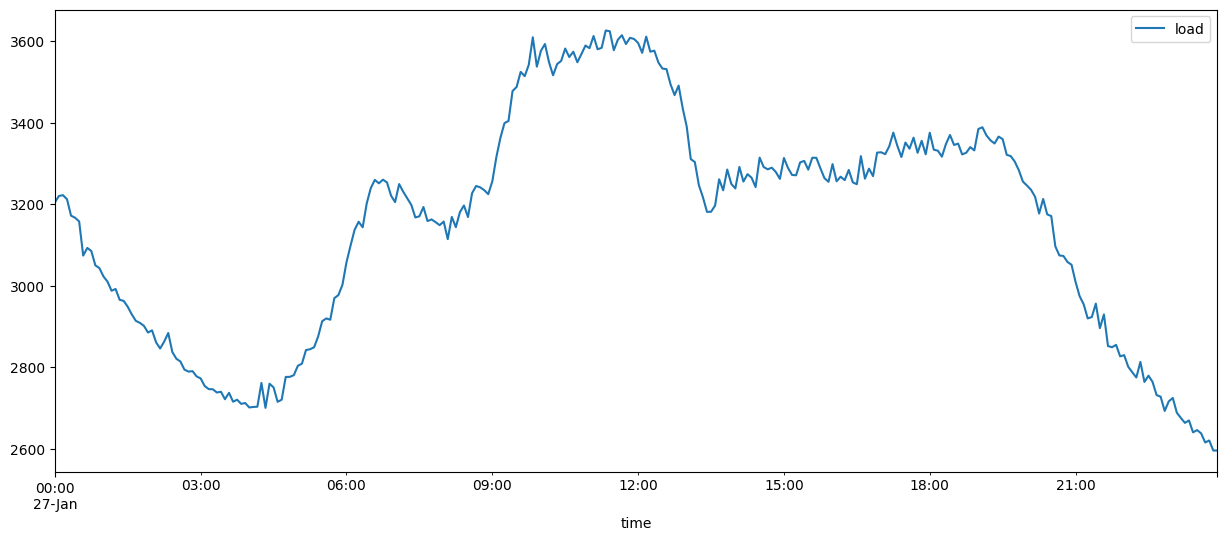

In [33]:
pred_df = pd.DataFrame(columns=["time", "load"])
pred_df["time"] = list(df2.index)
pred_df["load"] = rescaled_Y
pred_df['time'] = pd.to_datetime((pred_df['time']),dayfirst=True, format='mixed')
pred_df = pred_df.set_index('time')
pred_df.plot()

In [32]:
pred_df.to_excel('/kaggle/working/predicted_load_2023-05-01.xlsx')

### Loading the Actual Load on 1st March 2023

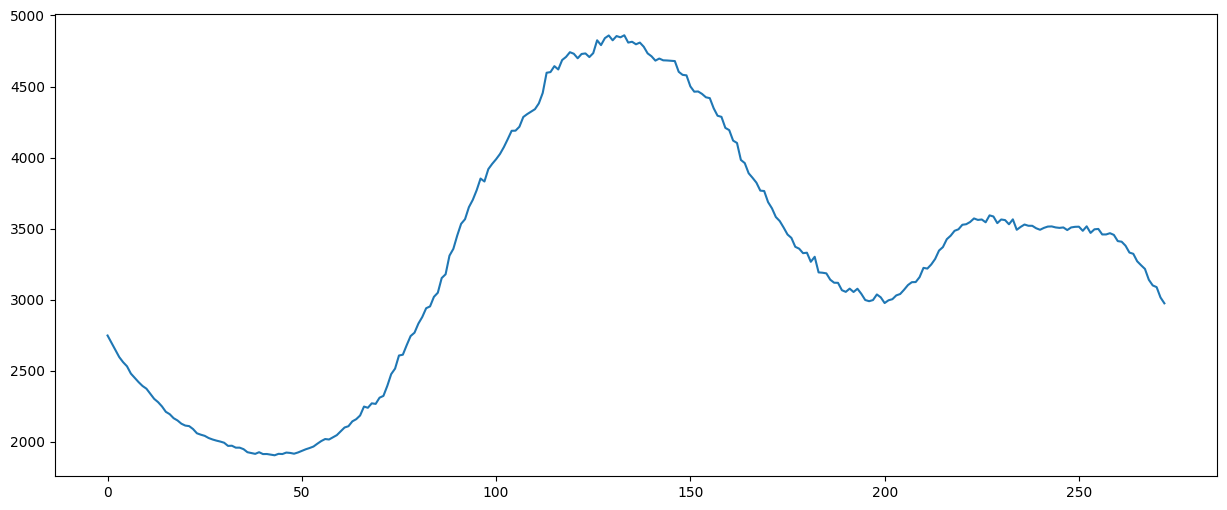

In [30]:
actual_load = np.load('/kaggle/input/load-data-26-jan-2024/load_26jan2024.npy')
plt.plot(actual_load)

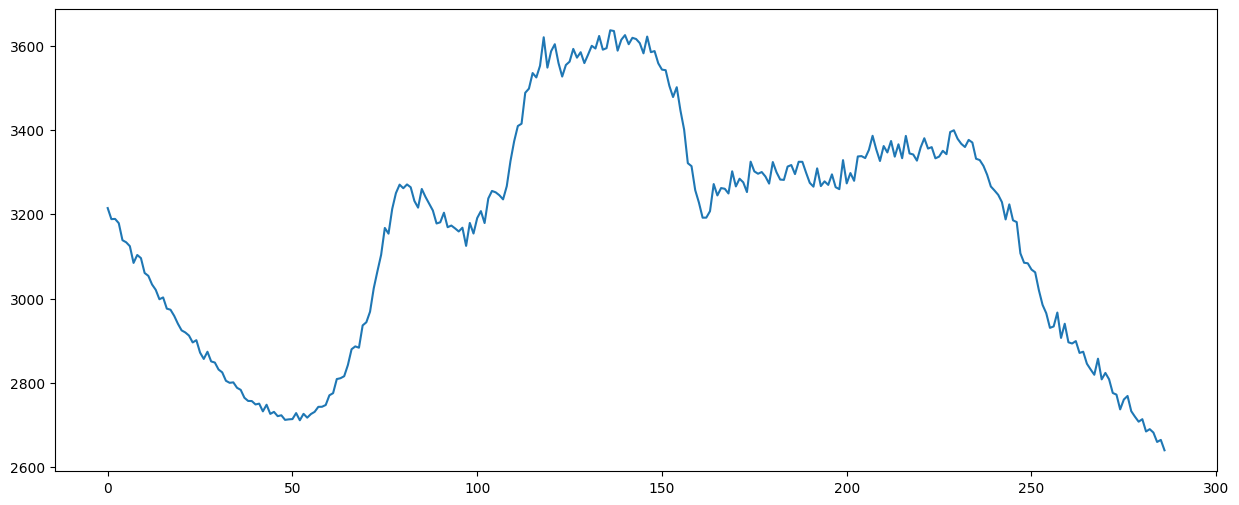

In [34]:
actual_load = np.load('/kaggle/input/load-may-1/load_1may.npy')
plt.plot(actual_load)

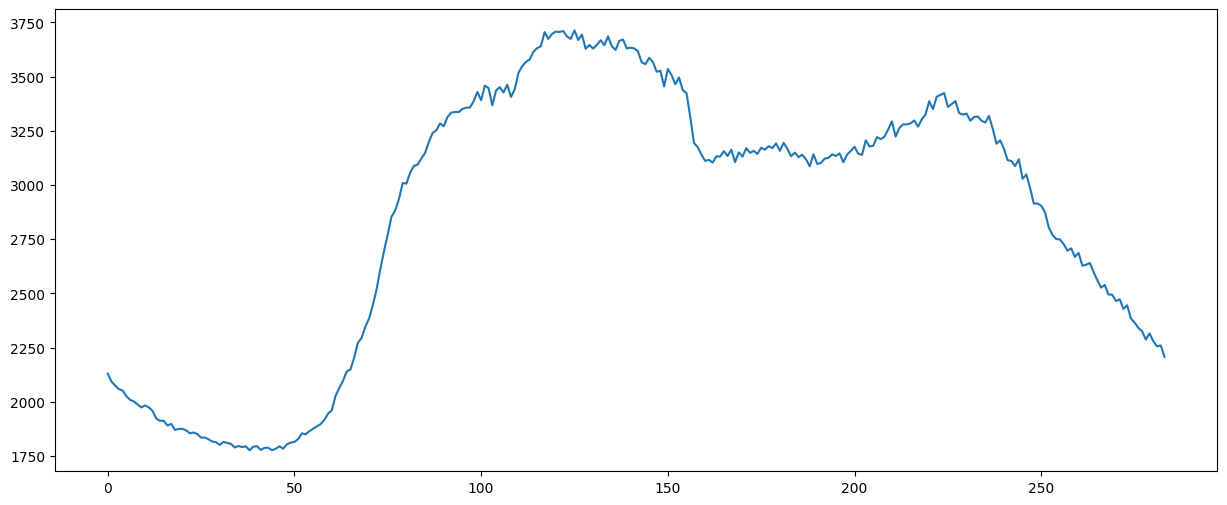

In [27]:
actual_load = np.load('/kaggle/input/load-mar-1/load_1mar.npy')
plt.plot(actual_load)

## 9. Final Comparison of Actual Load and Predicted Load values on 1st March 2023

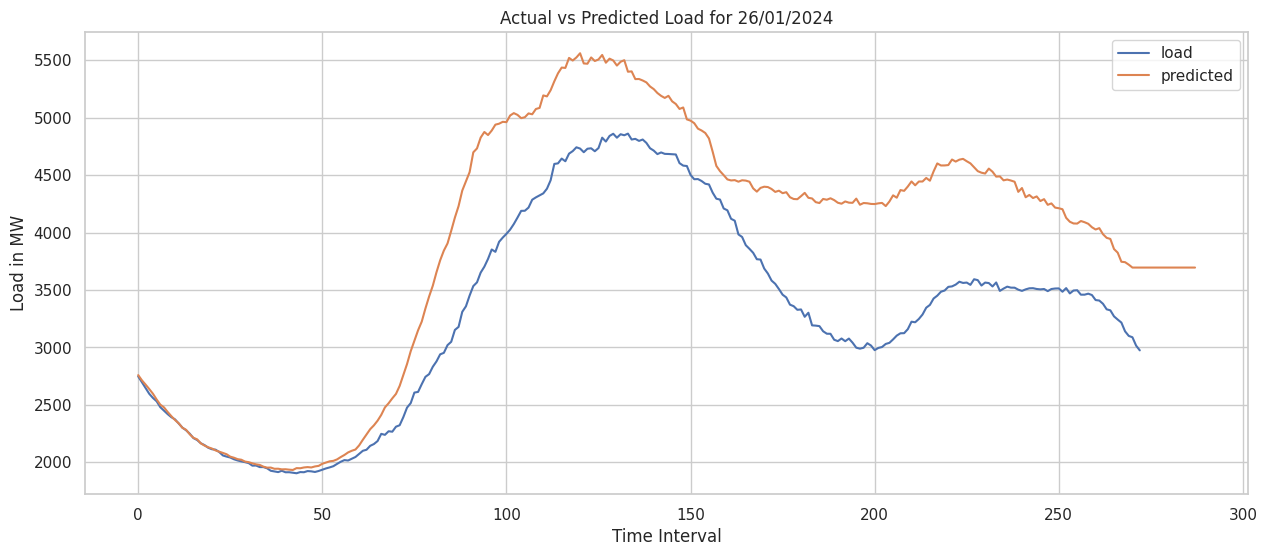

In [35]:
plt.plot(actual_load)
plt.plot(rescaled_Y)
plt.legend(['load', 'predicted'])
plt.xlabel('Time Interval')
plt.ylabel('Load in MW')
plt.title('Actual vs Predicted Load for 26/01/2024')
plt.savefig('/kaggle/working/lstm_2024_26jan_predicted_load4.png', dpi=600)

Text(0, 0.5, 'Load in MW')

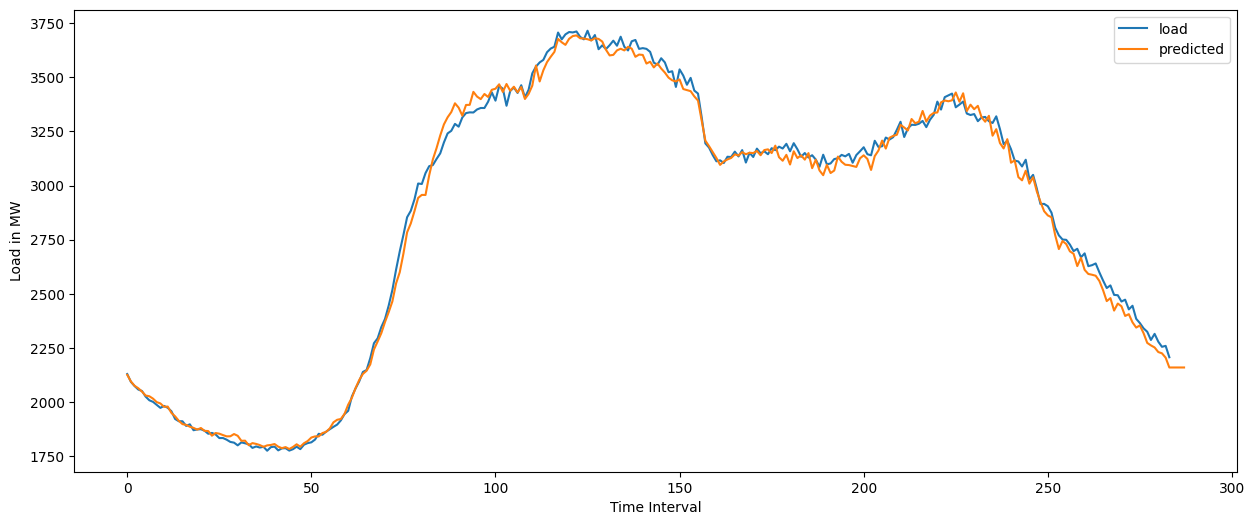

In [28]:
#import seaborn as sns
#sns.plot(actual_load[:270])
plt.plot(actual_load)
plt.plot(rescaled_Y)
plt.legend(['load', 'predicted'])
plt.xlabel('Time Interval')
plt.ylabel('Load in MW')
#plt.savefig('/kaggle/working/lstm_march_1st_predicted_load4.png', dpi=600)

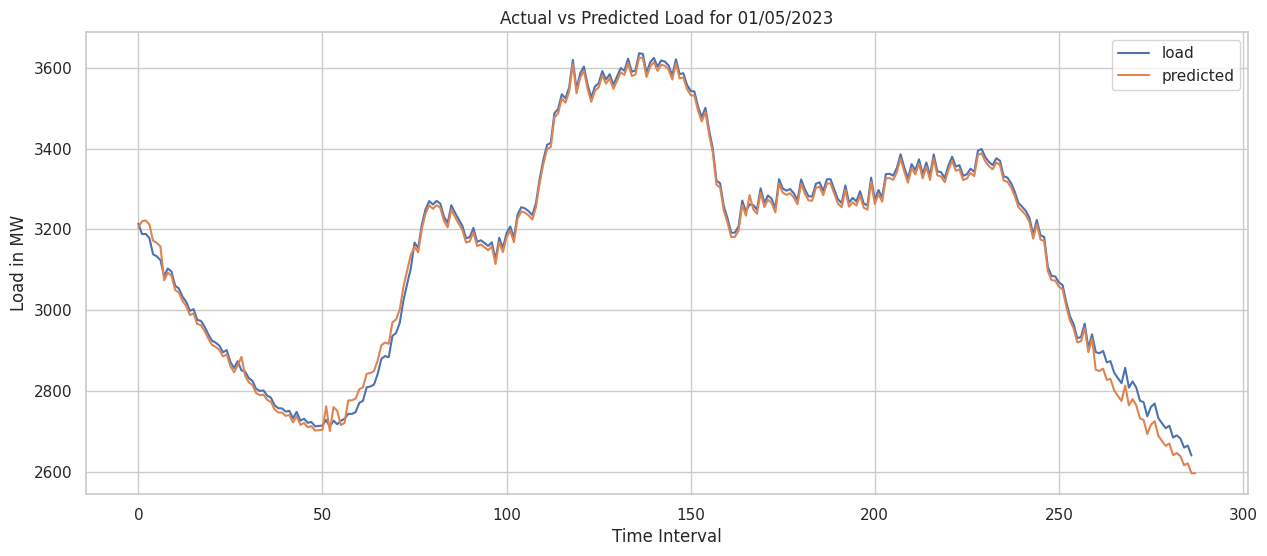

In [42]:
plt.plot(actual_load)
plt.plot(rescaled_Y)
plt.legend(['load', 'predicted'])
plt.xlabel('Time Interval')
plt.ylabel('Load in MW')
plt.title('Actual vs Predicted Load for 01/05/2023')
plt.savefig('/kaggle/working/lstm_may_1st_predicted_load5.png', dpi=600)

## 9. Final Comparison of Actual Load and Predicted Load values on 1st March 2023

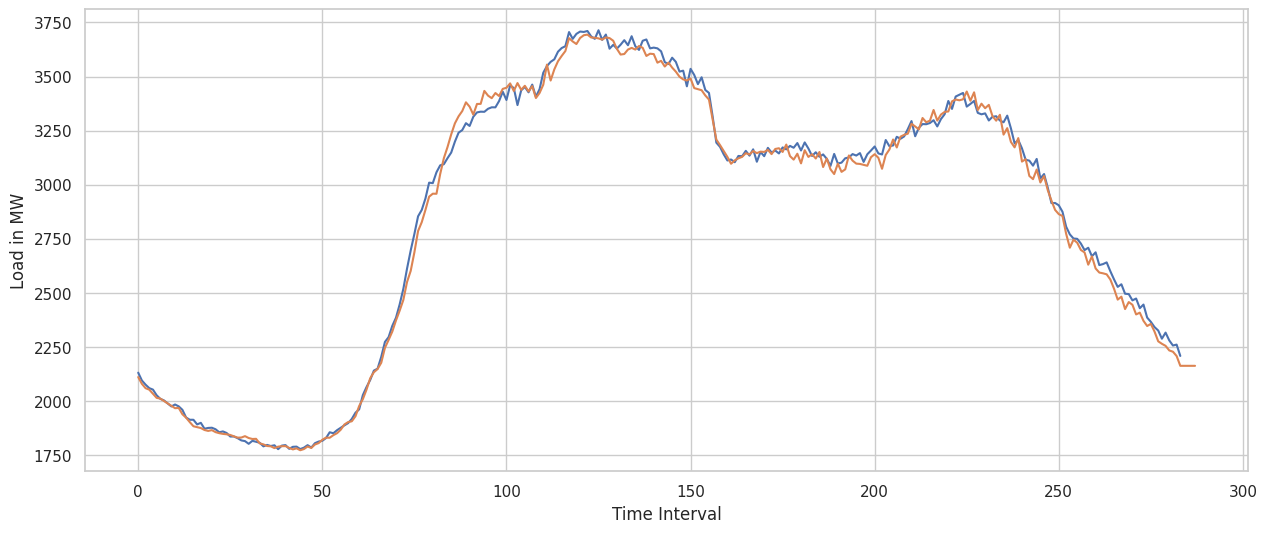

In [46]:
import seaborn as sns
sns.color_palette("pastel")
sns.set_theme(style="whitegrid")
sns.lineplot(actual_load, legend=True)
sns.lineplot(rescaled_Y, legend=True)
# plt.legend(['load', 'predicted'])
plt.xlabel('Time Interval')
plt.ylabel('Load in MW')
plt.savefig('/kaggle/working/lstm_march_1st_predicted_load3.png', dpi=600)

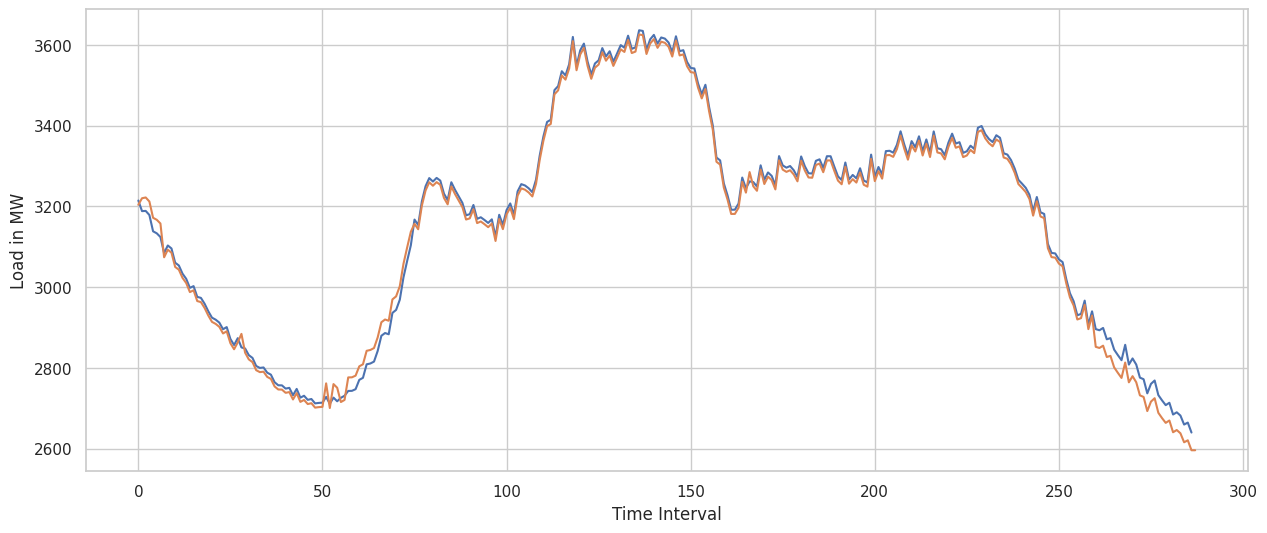

In [35]:
import seaborn as sns
sns.color_palette("pastel")
sns.set_theme(style="whitegrid")
sns.lineplot(actual_load, legend=True)
sns.lineplot(rescaled_Y, legend=True)
# plt.legend(['load', 'predicted'])
plt.xlabel('Time Interval')
plt.ylabel('Load in MW')
plt.savefig('/kaggle/working/lstm_may_1st_predicted_load3.png', dpi=600)

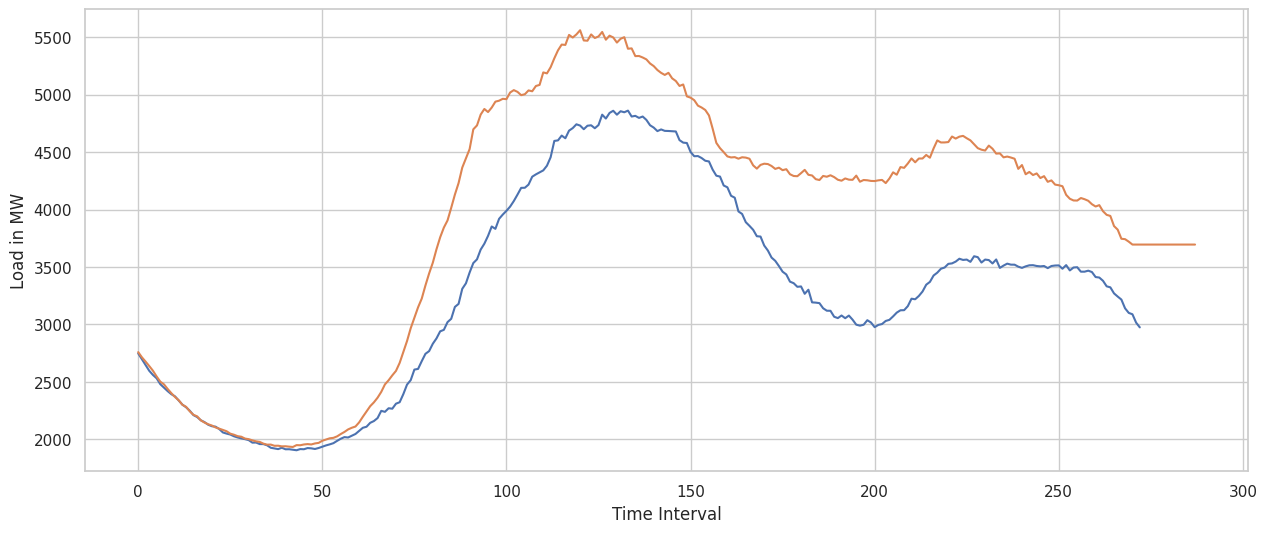

In [31]:
import seaborn as sns
sns.color_palette("pastel")
sns.set_theme(style="whitegrid")
sns.lineplot(actual_load, legend=True)
sns.lineplot(rescaled_Y, legend=True)
# plt.legend(['load', 'predicted'])
plt.xlabel('Time Interval')
plt.ylabel('Load in MW')
plt.savefig('/kaggle/working/lstm_2024_jan_26_predicted_load3.png', dpi=600)

## 10. Computing the accuracy of the model

### RMSE (Root-Mean-Squared Error)

In [33]:
RMSE = np.sqrt(np.sum(np.square(np.array(rescaled_Y[:273]) - actual_load[:273])) / len(actual_load)) 
print(RMSE)

741.7090682651864


In [29]:
RMSE = np.sqrt(np.sum(np.square(np.array(rescaled_Y[:288]) - actual_load[:288])) / len(actual_load)) 
print(RMSE)

37.10437827321403


In [38]:
RMSE = np.sqrt(np.sum(np.square(np.array(rescaled_Y[:287]) - actual_load)) / len(actual_load)) 
print(RMSE)

19.485253057220802


## RMSE = 37.1043 MW

### MAPE (Mean-Absolute Percentage Error)

In [34]:
APE = []
for time in range(273):
    per_err = (actual_load[time] - rescaled_Y[time]) / actual_load[time]
    per_err = abs(per_err*100)
    APE.append(per_err)

MAPE = sum(APE) / len(APE)

print(f"The MAPE value is {MAPE:.2f}%.")

The MAPE value is 17.75%.


In [30]:

APE = []
for time in range(288):
    per_err = (actual_load[time] - rescaled_Y[time]) / actual_load[time]
    per_err = abs(per_err*100)
    APE.append(per_err)

MAPE = sum(APE) / len(APE)

print(f"The MAPE value is {MAPE:.2f}%.")


The MAPE value is 0.99%.


In [40]:

APE = []
for time in range(287):
    per_err = (actual_load[time] - rescaled_Y[time]) / actual_load[time]
    per_err = abs(per_err*100)
    APE.append(per_err)

MAPE = sum(APE) / len(APE)

print(f"The MAPE value is {MAPE:.2f}%.")


The MAPE value is 0.52%.


## MAPE = 0.99%